In [49]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from scipy.linalg import svd

In [50]:
#load data
df = pd.read_csv('US_accidents_May19_Migrated Data.csv')

In [51]:
#Get a look at the data we're working with
df

,Airport_Code,Amenity,Astronomical_Twilight,Bump,Calculation1,City,Civil_Twilight,count of Bump,Count of Crossing,count Traffic Signal,...,Humidity(%),Number of Records,Precipitation(in),Pressure(in),Records,Start_Lat,Start_Lng,TMC,Wind_Chill(F),Wind_Speed(mph)
0,NaN,False,Day,False,Remaining,Garnet Valley,Day,0,0,0,...,NaN,1,NaN,NaN,1,39.852940,-75.461739,201.0,NaN,NaN
1,KDWH,False,Day,False,Remaining,Spring,Day,0,0,0,...,82.0,1,NaN,30.02,1,30.159246,-95.510826,201.0,NaN,5.8
2,KDSM,False,Day,False,Remaining,West des Moines,Day,0,0,0,...,79.0,1,NaN,30.04,1,41.586887,-93.806496,201.0,34.3,11.5
3,KCPS,False,Day,False,Remaining,Saint Louis,Day,0,0,0,...,84.0,1,NaN,30.10,1,38.634579,-90.186806,201.0,NaN,12.7
4,KXBP,False,Day,False,Remaining,Springtown,Day,0,0,0,...,96.0,1,NaN,29.95,1,32.930958,-97.641068,201.0,NaN,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243934,KBKF,False,Day,False,Remaining,Aurora,Day,0,1,1,...,48.0,1,NaN,30.00,1,39.709507,-104.814987,201.0,NaN,5.8
2243935,KBKF,False,Day,False,Remaining,Denver,Day,0,1,1,...,55.0,1,NaN,30.01,1,39.707298,-104.922256,201.0,NaN,5.8
2243936,KCOS,False,Day,False,Remaining,Colorado Springs,Day,0,1,1,...,20.0,1,NaN,29.86,1,38.833813,-104.821724,201.0,NaN,6.9
2243937,KCOS,False,Day,False,Remaining,Colorado Springs,Day,0,1,1,...,37.0,1,NaN,30.25,1,38.795475,-104.803535,201.0,NaN,6.9


We make a histogram of the severity column, and see that the values 2,3,4 are massively overrepresented as compared to values 0 and 1. 1 is still somewhat represented, but there are almost no datapoints with severity 0.

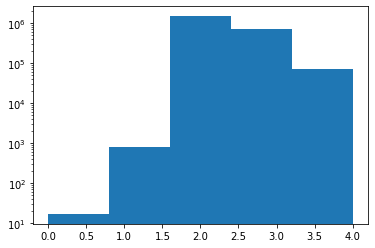

In [52]:
plt.hist(df['Severity'],bins=5)
plt.yscale('log')

In [53]:
#See what features we have in the datset
df.columns.values

array(['Airport_Code', 'Amenity', 'Astronomical_Twilight', 'Bump',
       'Calculation1', 'City', 'Civil_Twilight', 'count of Bump',
       'Count of Crossing', 'count Traffic Signal', 'Country', 'County',
       'Crossing', 'Description', 'End_Lat', 'End_Lng', 'End_Time',
       'Give_Way', 'ID', 'Junction', 'Nautical_Twilight', 'No_Exit',
       'Number', 'Railway', 'Roundabout', 'Severity', 'Side', 'Source',
       'Start_Time', 'State', 'Station', 'Stop', 'Street',
       'Sunrise_Sunset', 'Temperature(F)', 'Timezone', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Visibility(mi)',
       'Weather_Condition', 'Weather_Timestamp', 'Wind_Direction',
       'Zipcode', 'Count of accidents', 'count of county', 'Distance(mi)',
       'Humidity(%)', 'Number of Records', 'Precipitation(in)',
       'Pressure(in)', 'Records', 'Start_Lat', 'Start_Lng', 'TMC',
       'Wind_Chill(F)', 'Wind_Speed(mph)'], dtype=object)

Time should be an important feature for predicting the severity of an accident. One would expect that more serious accidents happen at night and during the winter for example. We can encode the time into a few different features: the year of the accident, the month, the hour of the day, and the weekday. Additionally, from the start_time and End_Time features, we can calculate how long the accident stop the flow of traffic, as a long traffic stoppage likely means that the accident was more severe.

In [54]:
#duration feature using start and end time
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.month

df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')
# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
df['Duration']=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

#adapted from https://medium.com/@vaibhavgope02/predicting-accident-severity-with-us-accidents-dataset-4aeaaae0b0af

In [56]:
set(df['Weekday'].values)

{'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'}

Select which features we would like to keep:

In [57]:
Good_columns = ['Year','Month','Hour','Weekday','Duration', 'count of Bump','Count of Crossing','count Traffic Signal','Crossing','Junction','No_Exit','Railway','Roundabout','Side','Station','Stop','Sunrise_Sunset','Traffic_Calming','Traffic_Signal','Temperature(F)','Visibility(mi)','Weather_Condition','Humidity(%)','Precipitation(in)','Pressure(in)','Wind_Speed(mph)','Start_Lat','Start_Lng','Severity']
#List of all used columns:
#the features listed below contains strings or true/false values that needs to be transformed:
to_be_transformed = ['Crossing','Junction','No_Exit','Railway','Roundabout','Side','Station','Stop','Sunrise_Sunset','Traffic_Calming','Traffic_Signal','Weather_Condition','Weekday']

In [58]:
new_df=df[Good_columns]
#fill 0-values in the Precipitation feature, since we assume that the lack of data means that there was no rainfall.
new_df['Precipitation(in)']=new_df['Precipitation(in)'].fillna(value=0)
new_df = new_df.dropna(axis=0,how='any').reset_index()


C:\Users\malth\AppData\Local\Temp/ipykernel_6176/255644069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Precipitation(in)']=new_df['Precipitation(in)'].fillna(value=0)


Weather conditions has many different values, so we one hot encode it, since one-hot encoding usually works well for learning categorical features with deep learning models since the model can intepret higher numbers in ordinal features as more important.

In [59]:
#One-hot encoding for the Weather_Condition parameter
y = pd.get_dummies(new_df.Weather_Condition, prefix='Weather_Condition')
y

,Weather_Condition_Blowing Sand,Weather_Condition_Blowing Snow,Weather_Condition_Clear,Weather_Condition_Drizzle,Weather_Condition_Dust Whirls,Weather_Condition_Fog,Weather_Condition_Funnel Cloud,Weather_Condition_Hail,Weather_Condition_Haze,Weather_Condition_Heavy Blowing Snow,...,Weather_Condition_Small Hail,Weather_Condition_Smoke,Weather_Condition_Snow,Weather_Condition_Snow Grains,Weather_Condition_Snow Showers,Weather_Condition_Squalls,Weather_Condition_Thunderstorm,Weather_Condition_Thunderstorms and Rain,Weather_Condition_Thunderstorms and Snow,Weather_Condition_Widespread Dust
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1780151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1780152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1780153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
new_df = pd.concat([new_df,y],axis=1)
new_df = new_df.drop('Weather_Condition',axis=1)
new_df.columns

Index(['index', 'Year', 'Month', 'Hour', 'Weekday', 'Duration',
       'count of Bump', 'Count of Crossing', 'count Traffic Signal',
       'Crossing', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Side',
       'Station', 'Stop', 'Sunrise_Sunset', 'Traffic_Calming',
       'Traffic_Signal', 'Temperature(F)', 'Visibility(mi)', 'Humidity(%)',
       'Precipitation(in)', 'Pressure(in)', 'Wind_Speed(mph)', 'Start_Lat',
       'Start_Lng', 'Severity', 'Weather_Condition_Blowing Sand',
       'Weather_Condition_Blowing Snow', 'Weather_Condition_Clear',
       'Weather_Condition_Drizzle', 'Weather_Condition_Dust Whirls',
       'Weather_Condition_Fog', 'Weather_Condition_Funnel Cloud',
       'Weather_Condition_Hail', 'Weather_Condition_Haze',
       'Weather_Condition_Heavy Blowing Snow',
       'Weather_Condition_Heavy Drizzle',
       'Weather_Condition_Heavy Freezing Drizzle',
       'Weather_Condition_Heavy Freezing Rain',
       'Weather_Condition_Heavy Ice Pellets', 'Weather_Condit

We could also want to one-hot encode Years, however the result in the report was achieved without one-hot encoded Years.

In [61]:
#One hot encode the Year feature we made earlier
y = pd.get_dummies(new_df.Year, prefix='Year')
y
new_df = pd.concat([new_df,y],axis=1)
new_df = new_df.drop('Year',axis=1)
new_df.columns

Index(['index', 'Month', 'Hour', 'Weekday', 'Duration', 'count of Bump',
       'Count of Crossing', 'count Traffic Signal', 'Crossing', 'Junction',
       'No_Exit', 'Railway', 'Roundabout', 'Side', 'Station', 'Stop',
       'Sunrise_Sunset', 'Traffic_Calming', 'Traffic_Signal', 'Temperature(F)',
       'Visibility(mi)', 'Humidity(%)', 'Precipitation(in)', 'Pressure(in)',
       'Wind_Speed(mph)', 'Start_Lat', 'Start_Lng', 'Severity',
       'Weather_Condition_Blowing Sand', 'Weather_Condition_Blowing Snow',
       'Weather_Condition_Clear', 'Weather_Condition_Drizzle',
       'Weather_Condition_Dust Whirls', 'Weather_Condition_Fog',
       'Weather_Condition_Funnel Cloud', 'Weather_Condition_Hail',
       'Weather_Condition_Haze', 'Weather_Condition_Heavy Blowing Snow',
       'Weather_Condition_Heavy Drizzle',
       'Weather_Condition_Heavy Freezing Drizzle',
       'Weather_Condition_Heavy Freezing Rain',
       'Weather_Condition_Heavy Ice Pellets', 'Weather_Condition_Heavy Rain'

We can also one-hot encode "Weekday". This was done rather than the cyclical transformation presented later for the model shown in the report.

In [ ]:
#One hot encode the Weekday feature we made earlier
y = pd.get_dummies(new_df.Weekday, prefix='Weekday')
y
new_df = pd.concat([new_df,y],axis=1)
new_df = new_df.drop('Weekday',axis=1)
new_df.columns

In [62]:
#Check for NaN-values:
new_df.isnull().values.any()

False

In [63]:
#change "true/false" features to binary, ordinal features, and categorical features to ordinal features.

#
to_be_transformed = []
for column in tqdm(new_df.columns):
    if type(new_df[column][0])==type('string'):
        to_be_transformed.append(column)
    elif new_df[column][0]==True or new_df[column][0]==False: #replace "true" with 1 and "false" with 0
        new_df[column]=new_df[column].astype(int)
#print which features still need to be transformed
print(to_be_transformed)
transform_dic = {}
for column in tqdm(to_be_transformed): #loop over the remaining columns
    dic = {}
    count = 0
    for item in new_df[column]: #loop over each element in the column
        if item == True:
            dic[item]=1
        elif item == False:
            dic[item]=0
        elif item not in dic:
            dic[item]=count
            count+=1
    transform_dic[column]=dic
#Now that we have the new values for the transformed columns we assign the new values
for column in tqdm(to_be_transformed):
    new_list = []
    for i in range(len(new_df[column])):
        new_list.append(transform_dic[column][new_df[column][i]])
    new_df[column]=new_list

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:02<00:00, 37.62it/s]


['Weekday', 'Side', 'Sunrise_Sunset']


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.63s/it]


In [64]:
backup_df=new_df.copy()#IGNORE THIS

In [65]:
#Since there are almost 0 cases where the severity is 0, we remove the points that have the value. This will likely improve performance.
new_df.drop(new_df[new_df.Severity==0].index,inplace=True)


In [66]:
#sanity check, check that transformation worked
set(new_df['Weekday'].values)

{0, 1, 2, 3, 4, 5, 6}

For the time features, we can use cyclical encoding. Cyclical encoding maps the features to sine and cosine. It is useful for time features, since hour 24 is essentially the same as hour 0. Based on the following article:https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
This was not done in the run shown in the report.

In [67]:
new_df['Hour_sin'] = np.sin(2*np.pi*new_df['Hour']/24.0)
new_df['Hour_cos'] = np.cos(2*np.pi*new_df['Hour']/24.0)
new_df['Month_sin'] = np.sin(2*np.pi*new_df['Month']/12)
new_df['Month_cos'] = np.cos(2*np.pi*new_df['Month']/12)
new_df['Weekday_sin'] = np.cos(2*np.pi*new_df['Weekday']/7)
new_df['Weekday_cos'] = np.cos(2*np.pi*new_df['Weekday']/7)


In [68]:
new_df.drop(['index','Hour','Month','Weekday'],axis=1,inplace=True)#drop old time columns

In [69]:
new_df.columns#sanity check

Index(['Duration', 'count of Bump', 'Count of Crossing',
       'count Traffic Signal', 'Crossing', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Side', 'Station', 'Stop', 'Sunrise_Sunset',
       'Traffic_Calming', 'Traffic_Signal', 'Temperature(F)', 'Visibility(mi)',
       'Humidity(%)', 'Precipitation(in)', 'Pressure(in)', 'Wind_Speed(mph)',
       'Start_Lat', 'Start_Lng', 'Severity', 'Weather_Condition_Blowing Sand',
       'Weather_Condition_Blowing Snow', 'Weather_Condition_Clear',
       'Weather_Condition_Drizzle', 'Weather_Condition_Dust Whirls',
       'Weather_Condition_Fog', 'Weather_Condition_Funnel Cloud',
       'Weather_Condition_Hail', 'Weather_Condition_Haze',
       'Weather_Condition_Heavy Blowing Snow',
       'Weather_Condition_Heavy Drizzle',
       'Weather_Condition_Heavy Freezing Drizzle',
       'Weather_Condition_Heavy Freezing Rain',
       'Weather_Condition_Heavy Ice Pellets', 'Weather_Condition_Heavy Rain',
       'Weather_Condition_Heavy Rai

In [70]:
#save finished dataframe as pickle. If running training code on google colab, upload this to google drive.
with open('final_df.pickle', 'wb') as handle:
    pickle.dump(new_df, handle, protocol=pickle.HIGHEST_PROTOCOL)